第162次迭代找到的次优解距离为：21.246537600251443，能量为：199.16209478568416，路径为：
g,d,f,e,h,c,a,b,g
第354次迭代找到的次优解距离为：20.830621427371835，能量为：204.15888369541483，路径为：
a,d,f,b,h,c,e,g,a
第1120次迭代找到的次优解距离为：19.76340381965992，能量为：192.9110384858056，路径为：
d,e,f,b,h,c,a,g,d
第1349次迭代找到的次优解距离为：19.177617382033016，能量为：499.1811473131642，路径为：
d,e,f,h,b,c,a,g,d
第1825次迭代找到的次优解距离为：19.039331962455627，能量为：178.61110454494076，路径为：
d,f,b,h,c,a,e,g,d
第2723次迭代找到的次优解距离为：17.29126786466034，能量为：391.225146987703，路径为：
d,f,h,c,b,a,e,g,d
第7795次迭代找到的次优解距离为：15.877054302287245，能量为：265.17940627473484，路径为：
c,b,h,f,g,e,d,a,c


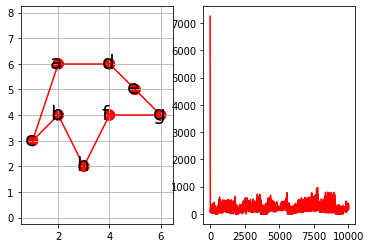

In [2]:
'''
连续型——Hopfield神经网络求解TSP
1、初始化权值（A,D,U0）
2、计算N个城市的距离矩阵dxy
3、初始化神经网络的输入电压Uxi和输出电压Vxi
4、利用动力微分方程计算：dUxi/dt
5、由一阶欧拉方法更新计算：Uxi(t+1) = Uxi(t) + dUxi/dt * step
6、由非线性函数sigmoid更新计算：Vxi(t) = 0.5 * (1 + th(Uxi/U0))
7、计算能量函数E
8、检查路径是否合法
'''
import numpy as np
from matplotlib import pyplot as plt
# 代价函数
def price_cn(vec1, vec2):
    return np.linalg.norm(np.array(vec1) - np.array(vec2))
def calc_distance(path):
    dis = 0.0
    for i in range(len(path) - 1):
        dis += distance[path[i]][path[i+1]]
    return dis
# 得到城市之间的距离矩阵
def get_distance(citys):
    N = len(citys)
    distance = np.zeros((N, N))
    for i, curr_point in enumerate(citys):
        line = []
        [line.append(price_cn(curr_point, other_point)) if i != j else line.append(0.0) for j, other_point in enumerate(citys)]
        distance[i] = line
    return distance
# 动态方程计算微分方程du
def calc_du(V, distance):
    a = np.sum(V, axis=0) - 1  # 按列相加
    b = np.sum(V, axis=1) - 1  # 按行相加
    t1 = np.zeros((N, N))
    t2 = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            t1[i, j] = a[j]
    for i in range(N):
        for j in range(N):
            t2[j, i] = b[j]
    # 将第一列移动到最后一列
    c_1 = V[:, 1:N]
    c_0 = np.zeros((N, 1))
    c_0[:, 0] = V[:, 0]
    c = np.concatenate((c_1, c_0), axis=1)
    c = np.dot(distance, c)
    return -A * (t1 + t2) - D * c
# 更新神经网络的输入电压U
def calc_U(U, du, step):
    return U + du * step
# 更新神经网络的输出电压V
def calc_V(U, U0):
    return 1 / 2 * (1 + np.tanh(U / U0))
# 计算当前网络的能量
def calc_energy(V, distance):
    t1 = np.sum(np.power(np.sum(V, axis=0) - 1, 2))
    t2 = np.sum(np.power(np.sum(V, axis=1) - 1, 2))
    idx = [i for i in range(1, N)]
    idx = idx + [0]
    Vt = V[:, idx]
    t3 = distance * Vt
    t3 = np.sum(np.sum(np.multiply(V, t3)))
    e = 0.5 * (A * (t1 + t2) + D * t3)
    return e
# 检查路径的正确性
def check_path(V):
    newV = np.zeros([N, N])
    route = []
    for i in range(N):
        mm = np.max(V[:, i])
        for j in range(N):
            if V[j, i] == mm:
                newV[j, i] = 1
                route += [j]
                break
    return route, newV
# 可视化画出哈密顿回路和能量趋势
def draw_H_and_E(citys, H_path, energys):
    fig = plt.figure()
    # 绘制哈密顿回路
    ax1 = fig.add_subplot(121)
    plt.xlim(0, 7)
    plt.ylim(0, 7)
    for (from_, to_) in H_path:
        p1 = plt.Circle(citys[from_], 0.2, color='red')
        p2 = plt.Circle(citys[to_], 0.2, color='red')
        ax1.add_patch(p1)
        ax1.add_patch(p2)
        ax1.plot((citys[from_][0], citys[to_][0]), (citys[from_][1], citys[to_][1]), color='red')
        ax1.annotate(text=chr(97 + to_), xy=citys[to_], xytext=(-8, -4), textcoords='offset points', fontsize=20)
    ax1.axis('equal')
    ax1.grid()
    # 绘制能量趋势图
    ax2 = fig.add_subplot(122)
    ax2.plot(np.arange(0, len(energys), 1), energys, color='red')
    plt.show()
if __name__ == '__main__':
    citys = np.array([[2, 6], [2, 4], [1, 3], [4, 6], [5, 5], [4, 4], [6, 4], [3, 2]])
    distance = get_distance(citys)
    N = len(citys)
    # 设置初始值
    A = N * N
    D = N / 2
    U0 = 0.0009  # 初始电压
    step = 0.0001  # 步长
    num_iter = 10000  # 迭代次数
    # 初始化神经网络的输入状态（电路的输入电压U）
    U = 1 / 2 * U0 * np.log(N - 1) + (2 * (np.random.random((N, N))) - 1)
    # 初始化神经网络的输出状态（电路的输出电压V）
    V = calc_V(U, U0)
    energys = np.array([0.0 for x in range(num_iter)])  # 每次迭代的能量
    best_distance = np.inf  # 最优距离
    best_route = []  # 最优路线
    H_path = []  # 哈密顿回路
    # 开始迭代训练网络
    for n in range(num_iter):
        # 利用动态方程计算du
        du = calc_du(V, distance)
        # 由一阶欧拉法更新下一个时间的输入状态（电路的输入电压U）
        U = calc_U(U, du, step)
        # 由sigmoid函数更新下一个时间的输出状态（电路的输出电压V）
        V = calc_V(U, U0)
        # 计算当前网络的能量E
        energys[n] = calc_energy(V, distance)
        # 检查路径的合法性
        route, newV = check_path(V)
        if len(np.unique(route)) == N:
            route.append(route[0])
            dis = calc_distance(route)
            if dis < best_distance:
                H_path = []
                best_distance = dis
                best_route = route
                [H_path.append((route[i], route[i + 1])) for i in range(len(route) - 1)]
                print('第{}次迭代找到的次优解距离为：{}，能量为：{}，路径为：'.format(n, best_distance, energys[n]))
                [print(chr(97 + v), end=',' if i < len(best_route) - 1 else '\n') for i, v in enumerate(best_route)]
    if len(H_path) > 0:
        draw_H_and_E(citys, H_path, energys)
    else:
        print('没有找到最优解')